In [73]:
import pandas as pd
import numpy as np
from glob import glob
import ahocorasick
from Bio import pairwise2,SeqIO
from Bio.pairwise2 import format_alignment
from tqdm import tqdm
import ast
import swifter
import datetime
import multiprocessing as mp
from pandarallel import pandarallel
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
tqdm.pandas()

In [5]:
final_pep_gene_symbol = pd.read_table("/home1/wangd/project/PXD016999/count/peps_gene_symbol.tsv")

In [6]:
final_pep_gene_symbol

,sequence_x,protein_accessions,peptidoform,gene_symbol
0,AAAAAAAAAPAAAATAATTAATTAATAAQ,GCA_109298,AAAAAAAAAPAAAATAATTAATTAATAAQ,SRP14
1,AAAAPAPPAGPR,GCA_161748,AAAAPAPPAGPR,PLK3
2,AAAGDLGGDHLAFSCDVAKEHDVQNTFEEMEK,GCA_60405,AAAGDLGGDHLAFSC[Carbamidomethyl]DVAKEHDVQNTFEEMEK,CBR4
3,AAAGDLGGDHLAFSCDVAKEHDVQNTFEEMEK,GCA_60405,AAAGDLGGDHLAFSC[Carbamidomethyl]DVAKEHDVQ[Deam...,CBR4
4,AAAGDLGGDHLAFSCDVAKEHDVQNTFEEMEK,GCA_60405,AAAGDLGGDHLAFSC[Carbamidomethyl]DVAKEHDVQ[Deam...,CBR4
...,...,...,...,...
6203,YWCNDGKNPGAVNACHLSCSALLQDNIADAVACAK,GCA_170013,YWC[Carbamidomethyl]NDGKN[Deamidated]PGAVNAC[C...,LYZ
6204,YWCNDGKNPGAVNACHLSCSALLQDNIADAVACAK,GCA_170013,YWC[Carbamidomethyl]NDGKN[Deamidated]PGAVN[Dea...,LYZ
6205,YWCNDGKNPGAVNACHLSCSALLQDNIADAVACAK,GCA_170013,YWC[Carbamidomethyl]NDGKN[Deamidated]PGAVNAC[C...,LYZ
6206,YWMHFCGGSLIHPQWVLTAAHCLGPDVK,"GCA_284206,GCA_284208",YWM[Oxidation]HFC[Carbamidomethyl]GGSLIHPQ[Dea...,TPSAB1


In [7]:
len(set(final_pep_gene_symbol["sequence_x"]))

3510

In [8]:
final_pep_gene_symbol_no_gene_symbol = final_pep_gene_symbol[final_pep_gene_symbol["gene_symbol"].isna()]
final_pep_gene_symbol_no_gene_symbol_set = set(final_pep_gene_symbol_no_gene_symbol["sequence_x"])
len(final_pep_gene_symbol_no_gene_symbol_set)

25

In [9]:
all_res_peps = set(final_pep_gene_symbol["sequence_x"])

In [10]:
gene_symbol_proteins = {}
proteins_info = {}
for record in SeqIO.parse("/home1/wangd/project/can_db/Homo_sapiens-GRCh38_all-pep.fa", 'fasta'):
    gene_symbol_list = [x for x in record.description.split(" ") if x.startswith('gene_symbol:')]
    if gene_symbol_list:
        gene_symbol = gene_symbol_list[0].split(':')[-1]
    else:
        continue
    try:
        gene_symbol_proteins[gene_symbol].append(str(record.seq) + ';' + str(record.description))
    except KeyError:
        gene_symbol_proteins[gene_symbol] = [str(record.seq) + ';' + str(record.description)]

    try:
        proteins_info[str(record.seq)].append(str(record.description))
    except KeyError:
        proteins_info[str(record.seq)] = [str(record.description)]

In [11]:
seq_gene_symbol_set = set()
seq_no_gene_symbol_set = set()
for index,row in final_pep_gene_symbol.iterrows():
    try:
        gene_symbols = row["gene_symbol"].split(",")
        for gene_symbol in gene_symbols:
            seq_gene_symbol_set.add(row["sequence_x"] + '+' + gene_symbol)
    except AttributeError:
        seq_no_gene_symbol_set.add(row["sequence_x"])

print("There are {} peptides with no corresponding gene symbol found.".format(len(seq_no_gene_symbol_set)))
for seq in seq_no_gene_symbol_set:
    print(seq)

There are 25 peptides with no corresponding gene symbol found.
AEDTAVYFCAK
NDNIPEQDSLGLSNLQK
ESGPVLVKPTETLTLTCTISGFSLSNAR
LLIFGASTR
YKSDSDNQQGSGVPSR
LSCAVSGFTFSSYAMHWVR
ASGYTYTDYYMHWVR
SAGGGTYYADSVK
LEEECEGREPGLETGTQAADCKDAPLK
NTLYHQMNSLRAEDTAVYYCAR
LEWMGWINTGNGNTK
SSPVFQIPKNDNIPEQDSLGLSNLQK
ANGGTTDYAAPVK
DLCPLLSEHGLQCSLEPHLNSNLCVYCCK
ASQSISTWLAWYQQKPGK
VLIYGASSLQSGVPSR
SKANGGTTDYAAPVK
TPESFLGPNAALVDLDSLVSRPGPTLPGAK
TGEVVLTQSPGTLSLSPGER
KTPESFLGPNAALVDLDSLVSRPGPTLPGAK
LEEECEGREPGLETGTQAADCK
ASGYTFTNNGITWVR
LSCAASGFTFSTYGMHWVR
NQVVLTMTNMNPVDTATYYCAR
DTSISTAYMDLSR


In [12]:
gene_symbol_set = set()
for i in seq_gene_symbol_set:
    if i.split("+")[1]:
        gene_symbol_set.add(i.split("+")[1])

In [13]:
len(gene_symbol_set)

1951

In [15]:
def get_details(start, pep_in_caonical, non_canonical_pep_seq):
    res = []
    i = 0
    j = 0
    for AA1, AA2 in zip(pep_in_caonical, non_canonical_pep_seq):
        i += 1
        j += 1
        if AA1 == AA2:
            continue
        if AA1 == '-' and AA2 != '-':
            # insertion
            res.append(str(start + i) + "-" + ">" + AA2)
            i -= 1
        elif AA2 == '-' and AA1 != '-':
            # deletion
            res.append(str(start + i) + AA1 + ">" + "-")
            j -= 1
        else:
            # substitution
            res.append(str(start + i) + AA1 + ">" + AA2)
    return res

In [16]:
def get_blast_canonical_mismatch1or2_info(pep,prot):
# def get_blast_canonical_mismatch1or2_info(x):
    non_canonical_pep_seq = pep
    # non_canonical_pep_seq = x["peptide"]
    canonical_seq = prot
    # canonical_seq = x["canonical_protein"]

    alignments = pairwise2.align.localms(sequenceA = canonical_seq,sequenceB = non_canonical_pep_seq,match = 1,mismatch = -1,open = -1,extend = -1,one_alignment_only=True)
    alignment = alignments[0]
    start = alignment.start
    end = alignment.end

    res = get_details(start,alignment.seqA[start:end], alignment.seqB[start:end])

    if len(res) == 0:
        score = alignment.score
        mismatch_nums = int(len(non_canonical_pep_seq) - score)
        if mismatch_nums in [1,2]:
            res_left = get_details(start-mismatch_nums,alignment.seqA[start-mismatch_nums:end], alignment.seqB[start-mismatch_nums:end])
            res_right = get_details(start,alignment.seqA[start:end+mismatch_nums], alignment.seqB[start:end+mismatch_nums])
            if len(res_left) < len(res_right):
                return res_left
            elif len(res_left) > len(res_right):
                return res_right
            else:
                l_num = 0
                r_num = 0
                for l in res_left:
                    if "-" in l:
                        l_num+=1
                for r in res_right:
                    if "-" in r:
                        r_num+=1
                if l_num > r_num:
                    return res_right
                else:
                    return res_left
        else:
            return ""
    elif len(res) in [1,2]:
        return res
    else:
        return ""

In [17]:
blast_infos = dict()
blast_infos_details = dict()
gene_symbol_no_protein_set = set()
for seq_gene_symbol in tqdm(seq_gene_symbol_set):
    pep_seq = seq_gene_symbol.split("+")[0]
    gene_symbol = seq_gene_symbol.split("+")[1]
    if gene_symbol in gene_symbol_proteins.keys():
        for info in gene_symbol_proteins[gene_symbol]:
            prot_seq = info.split(";")[0]
            prot_info = info.split(";")[1]

            alignments_score = pairwise2.align.localms(sequenceA = prot_seq,sequenceB = pep_seq,match = 1,mismatch = -1,open = -1,extend = -1,score_only = True)
            if alignments_score >= len(pep_seq) - 4:
                res = get_blast_canonical_mismatch1or2_info(pep_seq,prot_seq)
                if res:
                    blast_infos_details_key = pep_seq + ";" + prot_seq
                    blast_infos_details[blast_infos_details_key] = res

                    try:
                        blast_infos[seq_gene_symbol].append(info)
                    except KeyError:
                        blast_infos[seq_gene_symbol] = [info]
    else:
        gene_symbol_no_protein_set.add(gene_symbol)
print("There are {} gene_symbols with no corresponding canonical protein sequence found.".format(len(gene_symbol_no_protein_set)))
for gene_symbol in gene_symbol_no_protein_set:
    print(gene_symbol)

100%|██████████| 3537/3537 [20:00<00:00,  2.95it/s]  

There are 14 gene_symbols with no corresponding canonical protein sequence found.
DDX58
GBA
Pwp2
FAM207A
EEF1AKNMT
FAM160B1
UHRF1BP1
srpk1a
apol1
H2BS1
SKIV2L
CBWD2
WDR92
FAM160B2


#### Peptide + gene_symbol + protein

In [18]:
peptide_gene_symbol_protein = dict()
for key, value in blast_infos.items():
    prot_set = set()

    pep_seq = key.split("+")[0]
    gene_symbol = key.split("+")[1]

    for info in value:
        prot_set.add(info.split(";")[0])

    if peptide_gene_symbol_protein.get(pep_seq):
        peptide_gene_symbol_protein[pep_seq][gene_symbol] = prot_set
    else:
        peptide_gene_symbol_protein[pep_seq] = {gene_symbol:prot_set}

In [20]:
df = pd.DataFrame([(peptide, gene_symbol, ",".join(protein)) for peptide, inner_dict in peptide_gene_symbol_protein.items() for gene_symbol, protein in inner_dict.items()],
                  columns=['peptide', 'gene_symbol', 'protein'])
df.to_csv("/home1/wangd/project/PXD010154/count/blast_canonical_count/peptide_gene_symbol_protein.tsv", header=1, sep="\t", index = None)

In [23]:
df

,peptide,gene_symbol,protein
0,GVGGAVPGAVLEPVAPAPSVR,PKP3,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...
1,VLLTCWDPEENKMAPCEFGVLNNLANVLSQHLNQK,HLA-DMB,MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...
2,EITPPFKPAVAQPDDTFYFDTEFTSR,RPS6KA1,MPLAQLKEPWPLMELVPLDPENGQTSGEEAGLQPSKDEGVLKEISI...
3,SSPSSVTNSSYDGESDSQHHLSCEPVFQTNR,CRYBG3,MSSGRRRGSAPWHSFSRFFAPRSPSRDKEEEEEERPGTSPPPAPGR...
4,KQCQQLQTAIAEVEQR,KRT79,MRSSVSRQTYSTKGGFSSNSASGGSGSQARTSFSSVTVSRSSGSGG...
...,...,...,...
3418,DDANNDPQWCEEQLIAAK,PAICS,MATAEVLNIGKKLYEGKTKEVYELLDSPGKVLLQSKDQITAGNAAR...
3419,NSLYLQMNSLRTEDTTLYYCAK,IGHV3-43,MEFGLSWVFLVAILKGVQCEVQLVESGGVVVQPGGSLRLSCAASGF...
3420,CRPQEDTGWVLFPVNK,EPPK1,MSGHTLPPLPVPGTNSTEQASVPRAMAATLGAGTPPRPQARSIAGV...
3421,HEAFESDLAAHQDRVEQIAAIAQELNELDYHNAVNVNDR,ACTN2,MNQIEPGVQYNYVYDEDEYMIQEEEWDRDLLLDPAWEKQQRKTFTA...


In [24]:
df["canonical_protein_seq"] = df["protein"].apply(lambda x : x.split(","))
df = df.explode("canonical_protein_seq", ignore_index=True)
df = df.drop("protein", axis=1)

In [25]:
def get_blast_infos_details(x):
    return blast_infos_details[x["peptide"] + ";" + x["canonical_protein_seq"]]

df["mismatch_info"] = df.apply(lambda x: get_blast_infos_details(x), axis=1)
df["number_mismatches"] = df.apply(lambda x: len(x["mismatch_info"]), axis=1)
df["mismatch_info"] = df.apply(lambda x: ",".join(x["mismatch_info"]), axis=1)

In [27]:
def get_protein_infos(canonical_protein_seq):
    canonical_protein_IDs = set()
    canonical_transcript_IDs = set()
    gene_IDs = set()
    for info in proteins_info[canonical_protein_seq]:
        canonical_protein_IDs.add(info.split(" ")[0])
        canonical_transcript_IDs.add([x for x in info.split(" ") if x.startswith('transcript:')][0].split(':')[-1])
        gene_IDs.add([x for x in info.split(" ") if x.startswith('gene:')][0].split(':')[-1])
    return [",".join(canonical_protein_IDs), ",".join(canonical_transcript_IDs), ",".join(gene_IDs)]
df["canonical_protein_ID"] = df.apply(lambda x: get_protein_infos(x["canonical_protein_seq"])[0], axis=1)
df["canonical_transcript_ID"] = df.apply(lambda x: get_protein_infos(x["canonical_protein_seq"])[1], axis=1)
df["gene_ID"] = df.apply(lambda x: get_protein_infos(x["canonical_protein_seq"])[2], axis=1)

In [36]:
df.to_csv("/home1/wangd/project/PXD010154/count/blast_canonical_count/peptide_gene_symbol_protein_matching_info.tsv", header=1, sep="\t", index = None)

#### Add gca protein blast info

In [88]:
peptide_blast_res = pd.read_table("/home1/wangd/project/PXD010154/count/blast_canonical_count/peptide_gene_symbol_protein_matching_info.tsv")

In [89]:
peptide_blast_res

,peptide,gene_symbol,canonical_protein_seq,mismatch_info,number_mismatches,canonical_protein_ID,canonical_transcript_ID,gene_ID
0,GVGGAVPGAVLEPVAPAPSVR,PKP3,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,121R>P,1,ENSP00000434110.1,ENST00000528036.5,ENSG00000184363.10
1,GVGGAVPGAVLEPVAPAPSVR,PKP3,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,121R>P,1,ENSP00000435383.1,ENST00000533249.5,ENSG00000184363.10
2,GVGGAVPGAVLEPVAPAPSVR,PKP3,MQDGNFLLSALQPEAGVCSLALPSDLQLDRRGAEGPEAERLRAARV...,277R>P,1,ENSP00000331678.2,ENST00000331563.7,ENSG00000184363.10
3,VLLTCWDPEENKMAPCEFGVLNNLANVLSQHLNQK,HLA-DMB,MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...,71S>N,1,"ENSP00000394997.2,ENSP00000413062.2,ENSP000004...","ENST00000439344.6,ENST00000418759.6,ENST000004...","ENSG00000234154.10,ENSG00000241296.8,ENSG00000..."
4,VLLTCWDPEENKMAPCEFGVLNNLANVLSQHLNQK,HLA-DMB,MGHEQNQGAALLQMLPLLWLLPHSWAVPEEQSMITFLPLLLGLSLG...,103S>N,1,"ENSP00000398843.1,ENSP00000412415.1,ENSP000004...","ENST00000415090.1,ENST00000415927.1,ENST000004...","ENSG00000226264.10,ENSG00000234154.10,ENSG0000..."
...,...,...,...,...,...,...,...,...
11553,HEAFESDLAAHQDRVEQIAAIAQELNELDYHNAVNVNDR,ACTN2,PGVQYNYVYDEDEYMIQEEEWDRDLLLDPAWEKQQRKTFTAWCNSH...,439D>N,1,ENSP00000498926.1,ENST00000651275.1,ENSG00000077522.15
11554,HEAFESDLAAHQDRVEQIAAIAQELNELDYHNAVNVNDR,ACTN2,MNQIEPGVQYNYVYDEDEYMIQEEEWDRDLLLDPAWEKQQRKTFTA...,475D>N,1,ENSP00000355537.4,ENST00000366578.6,ENSG00000077522.15
11555,HEAFESDLAAHQDRVEQIAAIAQELNELDYHNAVNVNDR,ACTN2,MNQIEPGVQYNYVYDEDEYMIQEEEWDRDLLLDPAWEKQQRKTFTA...,444D>N,1,ENSP00000506961.1,ENST00000682015.1,ENSG00000077522.15
11556,AINLNRPILYGEQEESTVHVGR,LRRC34,MEKSQKINPFILHILQEVDEEIKKGLAAGITLNIAGNNRLVPVERV...,188S>G,1,ENSP00000429593.1,ENST00000522830.5,ENSG00000171757.17


In [90]:
peptides_blast = set(peptide_blast_res["peptide"].to_list())

In [91]:
auto = ahocorasick.Automaton()

for seq in peptides_blast:
    auto.add_word(seq, seq)

auto.make_automaton()

peps_prots = {}
for prot_file in tqdm(glob('/home1/wangd/project/can_db/GCA_peps/*.fa')):
    prot_seqs = set()
    prots_dict = {}
    parsed_file = SeqIO.parse(prot_file, 'fasta')
    sample_name = prot_file.split('/')[-1].split('-')[1]

    for record in parsed_file:
        try:
            prots_dict[str(record.seq)].append(sample_name + ' ' +  str(record.id) + ' ' +  str(record.seq) + ' ' + str(record.description))
        except KeyError:
            prots_dict[str(record.seq)] = [sample_name + ' ' + str(record.id) + ' ' +  str(record.seq) + ' ' + str(record.description)]

    found_prots = set()

    for prot_seq in prots_dict.keys():
        for end_ind, found in auto.iter(prot_seq):
            found_prots.add(found)
            try:
                peps_prots[found].append(prots_dict[prot_seq])
            except KeyError:
                peps_prots[found] = [prots_dict[prot_seq]]

100%|██████████| 97/97 [03:38<00:00,  2.26s/it]


In [92]:
def gca_prot_blast_canonical_info(gca_prots,canonical_prot):
    need_blast_again = set()
    score = float('-inf')
    for gca_prot in gca_prots:
        alignment_score = pairwise2.align.globalms(sequenceA = canonical_prot,sequenceB = gca_prot, match = 1,mismatch = -1,open = -1,extend = -1,score_only = True)
        if alignment_score > score:
            need_blast_again = {gca_prot}
            score = alignment_score
        elif alignment_score == score:
            need_blast_again.add(gca_prot)
        else:
            continue
    final_res = []
    # final_res = dict()
    for gca_prot in need_blast_again:
        alignments = pairwise2.align.globalms(sequenceA = canonical_prot,sequenceB = gca_prot, match = 1,mismatch = -1,open = -1,extend = -1,one_alignment_only=True)
        alignment = alignments[0]
        res = []
        i = 0
        j = 0
        for AA1, AA2 in zip(alignment.seqA, alignment.seqB):
            i += 1
            j += 1
            if AA1 == AA2:
                continue
            if AA1 == '-' and AA2 != '-':
                # insertion
                res.append(str(i) + "-" + ">" + AA2)
                i -= 1
            elif AA2 == '-' and AA1 != '-':
                # deletion
                res.append(str(i) + AA1 + ">" + "-")
                j -= 1
            else:
                # substitution
                res.append(str(i) + AA1 + ">" + AA2)
        # final_res.append({gca_prot:[res,alignment.score]})
        final_res.append([gca_prot,res,alignment.score])
        # final_res[gca_prot] = [res,alignment.score]
    return final_res

In [93]:
def gca_prot_blast_with_canonical_prot(x):
    canonical_prot = x["canonical_protein_seq"]
    gene_symbol_need = x["gene_symbol"]
    peptide = x["peptide"]
    gca_prot_sample = dict()
    for i in peps_prots[peptide]:
        for j in i:
            infos = j.split(" ")
            sample = infos[0]
            gca_prot = infos[2]
            try:
                gene_symbol = [x for x in infos if x.startswith('gene_symbol:')][0].split(':')[-1]
            except IndexError:
                continue
            if gene_symbol == gene_symbol_need:
                try:
                    gca_prot_sample[gca_prot].append(sample)
                except KeyError:
                    gca_prot_sample[gca_prot] = [sample]
    mismatch_info = gca_prot_blast_canonical_info(gca_prot_sample.keys(),canonical_prot)
    for info in mismatch_info:
        info.append(gca_prot_sample[info[0]])
    return mismatch_info
    # return [gca_prot_sample, mismatch_info]

In [94]:
start_time = datetime.datetime.now()
print(start_time)

# tqdm.pandas()
# peptide_blast_res["GCA_protein_seq"] = peptide_blast_res.progress_apply(gca_prot_blast_with_canonical_prot,axis=1)

pandarallel.initialize(nb_workers=38, use_memory_fs=False, progress_bar=True)
peptide_blast_res["GCA_protein_seq"] = peptide_blast_res.parallel_apply(gca_prot_blast_with_canonical_prot,axis=1)

end_time = datetime.datetime.now()
print(end_time)
print(end_time - start_time)

2024-04-18 12:54:05.995745
INFO: Pandarallel will run on 38 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


2024-04-18 20:39:35.305769
7:45:29.310024


In [95]:
peptide_blast_res = peptide_blast_res.explode("GCA_protein_seq", ignore_index=True)

In [101]:
peptide_blast_res.to_csv("/home1/wangd/project/PXD010154/count/blast_canonical_count/peptide_gene_symbol_protein_matching_info_add.tsv", header=1, sep="\t", index = None)

####  Create gca protein blast info tsv

In [103]:
peptide_blast_res = pd.read_table("/home1/wangd/project/PXD010154/count/blast_canonical_count/peptide_gene_symbol_protein_matching_info_add.tsv")

In [106]:
peptide_blast_res["GCA_protein_seq"] = peptide_blast_res["GCA_protein_seq"].apply(ast.literal_eval)

In [108]:
peptide_blast_res["samples"] = peptide_blast_res["GCA_protein_seq"].apply(lambda x: x[3])
peptide_blast_res["protein_mismatch_info"] = peptide_blast_res["GCA_protein_seq"].apply(lambda x: x[1])
peptide_blast_res["protein_number_mismatches"] = peptide_blast_res["protein_mismatch_info"].apply(lambda x:len(x))
peptide_blast_res["identity score"] = peptide_blast_res["GCA_protein_seq"].apply(lambda x: x[2])
peptide_blast_res["GCA_protein_seq"] = peptide_blast_res["GCA_protein_seq"].apply(lambda x: x[0])

peptide_blast_res["samples"] = peptide_blast_res["samples"].apply(lambda x: ",".join(x))
peptide_blast_res["protein_mismatch_info"] = peptide_blast_res["protein_mismatch_info"].apply(lambda x: ",".join(x))

In [109]:
gca_prot_peptide = dict()
for index, row in peptide_blast_res.iterrows():
    peptide_mismatch_info = [row["peptide"], row["mismatch_info"]]
    try:
        gca_prot_peptide[row["GCA_protein_seq"]].append(peptide_mismatch_info)
    except KeyError:
        gca_prot_peptide[row["GCA_protein_seq"]] = [peptide_mismatch_info]

In [110]:
peptide_blast_res = peptide_blast_res.drop(columns=['peptide','mismatch_info','number_mismatches'])
peptide_blast_res = peptide_blast_res.drop_duplicates()

In [111]:
peptide_blast_res = peptide_blast_res.rename(columns={'samples': 'sample_ids'})
peptide_blast_res = peptide_blast_res.rename(columns={'canonical_protein_seq': 'matching_canonical_protein_seq'})
peptide_blast_res = peptide_blast_res.rename(columns={'protein_mismatch_info': 'all_mismatch_info'})
peptide_blast_res = peptide_blast_res.rename(columns={'protein_number_mismatches': 'number_mismatches'})

In [112]:
def get_peptides(prot):
    peptides = set()
    for info in gca_prot_peptide[prot]:
        peptides.add(info[0] + "(" + info[1] + ")")
    return ";".join(peptides)
def get_peptide_mismatch_details(prot):
    mismatchs = set()
    for info in gca_prot_peptide[prot]:
        mismatchs = mismatchs.union(set(info[1].split(",")))
    return ",".join(mismatchs)
def get_other_mismatchs(x):
    return set(x["all_mismatch_info"].split(",")) - set(x["peptides_mismatch_info"].split(","))
peptide_blast_res["list of peptides belong to this protein"] = peptide_blast_res["GCA_protein_seq"].apply(get_peptides)
peptide_blast_res["peptides_mismatch_info"] = peptide_blast_res["GCA_protein_seq"].apply(get_peptide_mismatch_details)
peptide_blast_res["other_mismatch_info"] = peptide_blast_res.apply(lambda x: ",".join(get_other_mismatchs(x)), axis = 1)

In [113]:
peptide_blast_res

,gene_symbol,matching_canonical_protein_seq,canonical_protein_ID,canonical_transcript_ID,gene_ID,GCA_protein_seq,sample_ids,all_mismatch_info,number_mismatches,identity score,list of peptides belong to this protein,peptides_mismatch_info,other_mismatch_info
0,PKP3,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,ENSP00000434110.1,ENST00000528036.5,ENSG00000184363.10,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,"GCA_018504645.1,GCA_018469665.1",121R>P,1,154.0,GVGGAVPGAVLEPVAPAPSVR(121R>P),121R>P,
1,PKP3,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,ENSP00000435383.1,ENST00000533249.5,ENSG00000184363.10,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,"GCA_018504645.1,GCA_018469665.1",121R>P,1,195.0,GVGGAVPGAVLEPVAPAPSVR(121R>P),121R>P,
2,PKP3,MQDGNFLLSALQPEAGVCSLALPSDLQLDRRGAEGPEAERLRAARV...,ENSP00000331678.2,ENST00000331563.7,ENSG00000184363.10,MQDGNFLLSALQPEAGVCSLALPSDLQLDRRGAEGPEAERLRAARV...,"GCA_018504645.1,GCA_018469665.1",277R>P,1,795.0,GVGGAVPGAVLEPVAPAPSVR(277R>P),277R>P,
3,HLA-DMB,MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...,"ENSP00000394997.2,ENSP00000413062.2,ENSP000004...","ENST00000439344.6,ENST00000418759.6,ENST000004...","ENSG00000234154.10,ENSG00000241296.8,ENSG00000...",MITFLPLLLGLSLGCTGAGGFVAHVESACLLDDAGTPKDFTYCISF...,GCA_018469685.1,"28T>A,49D>V,71S>N,197T>I,248D>Y,249->T,249->P,...",17,229.0,MAPCEFGVLNNLANVLSQHLNQK(71S>N);VLLTCWDPEENKMAP...,"103S>N,71S>N","28T>A,256->W,251I>G,257L>S,248D>Y,249->T,197T>..."
4,HLA-DMB,MGHEQNQGAALLQMLPLLWLLPHSWAVPEEQSMITFLPLLLGLSLG...,"ENSP00000398843.1,ENSP00000412415.1,ENSP000004...","ENST00000415090.1,ENST00000415927.1,ENST000004...","ENSG00000226264.10,ENSG00000234154.10,ENSG0000...",MITFLPLLLGLSLGCTGAGGFVAHVESACLLDDAGTPKDFTYCISF...,GCA_018469685.1,"1M>-,2G>-,3H>-,4E>-,5Q>-,6N>-,7Q>-,8G>-,9A>-,1...",155,-15.0,MAPCEFGVLNNLANVLSQHLNQK(71S>N);VLLTCWDPEENKMAP...,"103S>N,71S>N","6N>-,3H>-,13Q>-,26A>-,176->C,176->K,30E>-,81D>..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12451,IGHV3-43,MEFGLSWVFLVAILKGVQCEVQLVESGGVVVQPGGSLRLSCAASGF...,"ENSP00000487611.1,ENSP00000399826.1","ENST00000434710.1,ENST00000633040.1","ENSG00000232216.1,ENSG00000282151.1",MEFGLSWVFLVAILKGVQCEVQLVESGGVVVQPGGSLRLSCAASGF...,GCA_018469705.1,111A>T,1,116.0,NSLYLQMNSLRTEDTTLYYCAK(111A>T),111A>T,
12452,EPPK1,MSGHTLPPLPVPGTNSTEQASVPRAMAATLGAGTPPRPQARSIAGV...,ENSP00000484472.1,ENST00000615648.2,ENSG00000261150.3,MSGHTLPPLPVPGTNSTEQASVPRAMAATLGAGTPPRPQARSIAGV...,GCA_018852595.1,"544K>E,1400N>S,1507T>A,2081L>V,2624A>-,2625A>-",6,5076.0,CRPQEDTGWVLFPVNK(2081L>V),2081L>V,"544K>E,2624A>-,2625A>-,1507T>A,1400N>S"
12453,EPPK1,MAATLGAGTPPRPQARSIAGVYVEASGQAQSVYAAMEQGLLPAGLG...,ENSP00000456124.2,ENST00000568225.2,ENSG00000261150.3,MAATLGAGTPPRPQARSIAGVYVEASGQAQSVYAAMEQGLLPAGLG...,GCA_018852595.1,"519K>E,1375N>S,1482T>A,2056L>V,2599A>-,2600A>-",6,5051.0,CRPQEDTGWVLFPVNK(2056L>V),2056L>V,"1482T>A,1375N>S,2600A>-,2599A>-,519K>E"
12459,LRRC34,MEKSQKINPFILHILQEVDEEIKKGLAAGITLNIAGNNRLVPVERV...,ENSP00000429593.1,ENST00000522830.5,ENSG00000171757.17,MEKSQKINPFILHILQEVDEEIKKGLAAGITLNIAGNNRLVPVERV...,"GCA_018504645.1,GCA_018469925.1,GCA_018503585....",188S>G,1,401.0,AINLNRPILYGEQEESTVHVGR(188S>G),188S>G,


In [114]:
peptide_blast_res = peptide_blast_res[['GCA_protein_seq', 'sample_ids', 'list of peptides belong to this protein', 'gene_symbol', 'matching_canonical_protein_seq', 'all_mismatch_info', 'number_mismatches', 'identity score', 'peptides_mismatch_info', 'other_mismatch_info', 'canonical_protein_ID', 'canonical_transcript_ID','gene_ID']]

In [115]:
peptide_blast_res

,GCA_protein_seq,sample_ids,list of peptides belong to this protein,gene_symbol,matching_canonical_protein_seq,all_mismatch_info,number_mismatches,identity score,peptides_mismatch_info,other_mismatch_info,canonical_protein_ID,canonical_transcript_ID,gene_ID
0,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,"GCA_018504645.1,GCA_018469665.1",GVGGAVPGAVLEPVAPAPSVR(121R>P),PKP3,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,121R>P,1,154.0,121R>P,,ENSP00000434110.1,ENST00000528036.5,ENSG00000184363.10
1,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,"GCA_018504645.1,GCA_018469665.1",GVGGAVPGAVLEPVAPAPSVR(121R>P),PKP3,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,121R>P,1,195.0,121R>P,,ENSP00000435383.1,ENST00000533249.5,ENSG00000184363.10
2,MQDGNFLLSALQPEAGVCSLALPSDLQLDRRGAEGPEAERLRAARV...,"GCA_018504645.1,GCA_018469665.1",GVGGAVPGAVLEPVAPAPSVR(277R>P),PKP3,MQDGNFLLSALQPEAGVCSLALPSDLQLDRRGAEGPEAERLRAARV...,277R>P,1,795.0,277R>P,,ENSP00000331678.2,ENST00000331563.7,ENSG00000184363.10
3,MITFLPLLLGLSLGCTGAGGFVAHVESACLLDDAGTPKDFTYCISF...,GCA_018469685.1,MAPCEFGVLNNLANVLSQHLNQK(71S>N);VLLTCWDPEENKMAP...,HLA-DMB,MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...,"28T>A,49D>V,71S>N,197T>I,248D>Y,249->T,249->P,...",17,229.0,"103S>N,71S>N","28T>A,256->W,251I>G,257L>S,248D>Y,249->T,197T>...","ENSP00000394997.2,ENSP00000413062.2,ENSP000004...","ENST00000439344.6,ENST00000418759.6,ENST000004...","ENSG00000234154.10,ENSG00000241296.8,ENSG00000..."
4,MITFLPLLLGLSLGCTGAGGFVAHVESACLLDDAGTPKDFTYCISF...,GCA_018469685.1,MAPCEFGVLNNLANVLSQHLNQK(71S>N);VLLTCWDPEENKMAP...,HLA-DMB,MGHEQNQGAALLQMLPLLWLLPHSWAVPEEQSMITFLPLLLGLSLG...,"1M>-,2G>-,3H>-,4E>-,5Q>-,6N>-,7Q>-,8G>-,9A>-,1...",155,-15.0,"103S>N,71S>N","6N>-,3H>-,13Q>-,26A>-,176->C,176->K,30E>-,81D>...","ENSP00000398843.1,ENSP00000412415.1,ENSP000004...","ENST00000415090.1,ENST00000415927.1,ENST000004...","ENSG00000226264.10,ENSG00000234154.10,ENSG0000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12451,MEFGLSWVFLVAILKGVQCEVQLVESGGVVVQPGGSLRLSCAASGF...,GCA_018469705.1,NSLYLQMNSLRTEDTTLYYCAK(111A>T),IGHV3-43,MEFGLSWVFLVAILKGVQCEVQLVESGGVVVQPGGSLRLSCAASGF...,111A>T,1,116.0,111A>T,,"ENSP00000487611.1,ENSP00000399826.1","ENST00000434710.1,ENST00000633040.1","ENSG00000232216.1,ENSG00000282151.1"
12452,MSGHTLPPLPVPGTNSTEQASVPRAMAATLGAGTPPRPQARSIAGV...,GCA_018852595.1,CRPQEDTGWVLFPVNK(2081L>V),EPPK1,MSGHTLPPLPVPGTNSTEQASVPRAMAATLGAGTPPRPQARSIAGV...,"544K>E,1400N>S,1507T>A,2081L>V,2624A>-,2625A>-",6,5076.0,2081L>V,"544K>E,2624A>-,2625A>-,1507T>A,1400N>S",ENSP00000484472.1,ENST00000615648.2,ENSG00000261150.3
12453,MAATLGAGTPPRPQARSIAGVYVEASGQAQSVYAAMEQGLLPAGLG...,GCA_018852595.1,CRPQEDTGWVLFPVNK(2056L>V),EPPK1,MAATLGAGTPPRPQARSIAGVYVEASGQAQSVYAAMEQGLLPAGLG...,"519K>E,1375N>S,1482T>A,2056L>V,2599A>-,2600A>-",6,5051.0,2056L>V,"1482T>A,1375N>S,2600A>-,2599A>-,519K>E",ENSP00000456124.2,ENST00000568225.2,ENSG00000261150.3
12459,MEKSQKINPFILHILQEVDEEIKKGLAAGITLNIAGNNRLVPVERV...,"GCA_018504645.1,GCA_018469925.1,GCA_018503585....",AINLNRPILYGEQEESTVHVGR(188S>G),LRRC34,MEKSQKINPFILHILQEVDEEIKKGLAAGITLNIAGNNRLVPVERV...,188S>G,1,401.0,188S>G,,ENSP00000429593.1,ENST00000522830.5,ENSG00000171757.17


In [116]:
peptide_blast_res.to_csv("/home1/wangd/project/PXD010154/count/blast_canonical_count/GCA_canonical_prot_matching_info.tsv", header=1, sep="\t", index = None)

In [118]:
peptide_blast_res = pd.read_table("/home1/wangd/project/PXD010154/count/blast_canonical_count/GCA_canonical_prot_matching_info.tsv")

In [119]:
peptide_blast_res[peptide_blast_res['number_mismatches']>10]

,GCA_protein_seq,sample_ids,list of peptides belong to this protein,gene_symbol,matching_canonical_protein_seq,all_mismatch_info,number_mismatches,identity score,peptides_mismatch_info,other_mismatch_info,canonical_protein_ID,canonical_transcript_ID,gene_ID
3,MITFLPLLLGLSLGCTGAGGFVAHVESACLLDDAGTPKDFTYCISF...,GCA_018469685.1,MAPCEFGVLNNLANVLSQHLNQK(71S>N);VLLTCWDPEENKMAP...,HLA-DMB,MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...,"28T>A,49D>V,71S>N,197T>I,248D>Y,249->T,249->P,...",17,229.0,"103S>N,71S>N","28T>A,256->W,251I>G,257L>S,248D>Y,249->T,197T>...","ENSP00000394997.2,ENSP00000413062.2,ENSP000004...","ENST00000439344.6,ENST00000418759.6,ENST000004...","ENSG00000234154.10,ENSG00000241296.8,ENSG00000..."
4,MITFLPLLLGLSLGCTGAGGFVAHVESACLLDDAGTPKDFTYCISF...,GCA_018469685.1,MAPCEFGVLNNLANVLSQHLNQK(71S>N);VLLTCWDPEENKMAP...,HLA-DMB,MGHEQNQGAALLQMLPLLWLLPHSWAVPEEQSMITFLPLLLGLSLG...,"1M>-,2G>-,3H>-,4E>-,5Q>-,6N>-,7Q>-,8G>-,9A>-,1...",155,-15.0,"103S>N,71S>N","6N>-,3H>-,13Q>-,26A>-,176->C,176->K,30E>-,81D>...","ENSP00000398843.1,ENSP00000412415.1,ENSP000004...","ENST00000415090.1,ENST00000415927.1,ENST000004...","ENSG00000226264.10,ENSG00000234154.10,ENSG0000..."
7,MITFLPLLLGLSLGCTGAGGFVAHVESACLLDDAGTPKDFTYCISF...,GCA_018469685.1,MAPCEFGVLNNLANVLSQHLNQK(71S>N);VLLTCWDPEENKMAP...,HLA-DMB,MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...,"28T>A,49D>V,71S>N,248D>Y,249->T,249->P,250I>P,...",16,231.0,"103S>N,71S>N","28T>A,256->W,251I>G,257L>S,248D>Y,249->T,249->...","ENSP00000396075.2,ENSP00000402800.2,ENSP000003...","ENST00000428864.6,ENST00000447454.6,ENST000004...","ENSG00000226264.10,ENSG00000241674.8,ENSG00000..."
15,MFDHNGKIIQKTPYPRPRGTTVSVQQLFSTLPVRHKEFQRNIKKEY...,"GCA_018473305.1,GCA_018473305.1",EAVSSSQGPSDPTDR(344H>Q);EAVSSSQGPSDPTDR(292H>Q...,PMS2,MFDHNGKIIQKTPYPRPRGTTVSVQQLFSTLPVRHKEFQRNIKKEY...,"195->E,195->C,195->V,195->D,195->I,195->N,195-...",54,619.0,"288H>Q,344H>Q,292H>Q","195->S,198->D,198->Q,195->D,196->V,195->I,195-...",ENSP00000514626.1,ENST00000699825.1,ENSG00000122512.17
17,MERAESSSTEPAKAIKPIDQKSVHQICSGQVVLSLSTAVKELVENS...,GCA_018473305.1,EAVSSSQGPSDPTDR(423H>Q);EAVSSSQGPSDPTDR(413H>Q...,PMS2,MERAESSSTEPAKAIKPIDRKSVHQICSGQVVLSLSTAVKELVENS...,"20R>Q,180->E,180->Y,180->A,180->K,180->M,180->...",59,744.0,"423H>Q,413H>Q,427H>Q,443H>Q,479H>Q,541H>Q,478H>Q","182->T,180->E,181->C,182->V,180->V,20R>Q,180->...",ENSP00000514628.1,ENST00000699827.1,ENSG00000122512.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"GCA_018505865.1,GCA_018470435.1,GCA_018504665....","SGAHSFISGLPQGYDTEVGEAGSQLSGGQQQAVALAR(574D>G,5...",TAP1,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"333I>V,458V>L,637D>G,648R>Q,678Q>-,679L>-,681S...",127,581.0,"594D>G,605R>Q,648R>Q,574D>G,708R>Q,697D>G,585R...","718T>-,713W>Y,333I>V,683M>-,719K>-,709D>-,458V...",ENSP00000513711.1,ENST00000698423.1,ENSG00000168394.13
9492,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"GCA_018505865.1,GCA_018470435.1,GCA_018504665....","SGAHSFISGLPQGYDTEVGEAGSQLSGGQQQAVALAR(574D>G,5...",TAP1,MAELLASAGSACSWDFPRAPPSFPPPAASRGGLGGTRSFRPHRGAE...,"1M>-,2A>-,3E>-,4L>-,5L>-,6A>-,7S>-,8A>-,9G>-,1...",65,678.0,"594D>G,605R>Q,648R>Q,574D>G,708R>Q,697D>G,585R...","4L>-,31G>-,26P>-,8A>-,32G>-,6A>-,58R>-,60P>-,7...",ENSP00000412933.2,ENST00000428324.2,ENSG00000224748.4
9494,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"GCA_018505865.1,GCA_018470435.1,GCA_018504665....","SGAHSFISGLPQGYDTEVGEAGSQLSGGQQQAVALAR(574D>G,5...",TAP1,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"333I>V,417->I,417->S,417->G,417->M,417->L,417-...",46,656.0,"594D>G,605R>Q,648R>Q,574D>G,708R>Q,697D>G,585R...","421->G,333I>V,421->F,417->M,418->G,419->I,420-...",ENSP00000513712.1,ENST00000698424.1,ENSG00000168394.13
9495,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"GCA_018505865.1,GCA_018470435.1,GCA_018504665....","SGAHSFISGLPQGYDTEVGEAGSQLSGGQQQAVALAR(574D>G,5...",TAP1,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"333I>V,458->

In [120]:
value_counts1 = peptide_blast_res[peptide_blast_res['number_mismatches']<=10]['number_mismatches'].value_counts()
# value_counts1 = peptide_blast_res['number_mismatches'].value_counts()
value_counts1

1     4786
2     1588
3      622
4      318
5      151
6      113
7       76
8       52
10      36
9       34
Name: number_mismatches, dtype: int64

<Axes: >

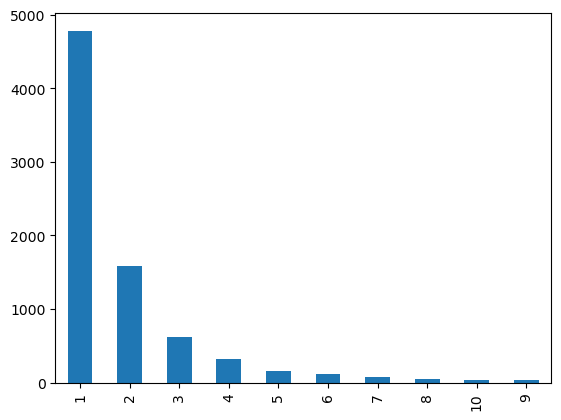

In [121]:
value_counts1.plot(kind='bar')  

In [122]:
peptide_blast_res['other_number_mismatches'] = peptide_blast_res['other_mismatch_info'].apply(lambda x: len(x.split(",")) if pd.notna(x) else 0)  

In [123]:
peptide_blast_res[peptide_blast_res['other_number_mismatches']>10]

,GCA_protein_seq,sample_ids,list of peptides belong to this protein,gene_symbol,matching_canonical_protein_seq,all_mismatch_info,number_mismatches,identity score,peptides_mismatch_info,other_mismatch_info,canonical_protein_ID,canonical_transcript_ID,gene_ID,other_number_mismatches
3,MITFLPLLLGLSLGCTGAGGFVAHVESACLLDDAGTPKDFTYCISF...,GCA_018469685.1,MAPCEFGVLNNLANVLSQHLNQK(71S>N);VLLTCWDPEENKMAP...,HLA-DMB,MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...,"28T>A,49D>V,71S>N,197T>I,248D>Y,249->T,249->P,...",17,229.0,"103S>N,71S>N","28T>A,256->W,251I>G,257L>S,248D>Y,249->T,197T>...","ENSP00000394997.2,ENSP00000413062.2,ENSP000004...","ENST00000439344.6,ENST00000418759.6,ENST000004...","ENSG00000234154.10,ENSG00000241296.8,ENSG00000...",16
4,MITFLPLLLGLSLGCTGAGGFVAHVESACLLDDAGTPKDFTYCISF...,GCA_018469685.1,MAPCEFGVLNNLANVLSQHLNQK(71S>N);VLLTCWDPEENKMAP...,HLA-DMB,MGHEQNQGAALLQMLPLLWLLPHSWAVPEEQSMITFLPLLLGLSLG...,"1M>-,2G>-,3H>-,4E>-,5Q>-,6N>-,7Q>-,8G>-,9A>-,1...",155,-15.0,"103S>N,71S>N","6N>-,3H>-,13Q>-,26A>-,176->C,176->K,30E>-,81D>...","ENSP00000398843.1,ENSP00000412415.1,ENSP000004...","ENST00000415090.1,ENST00000415927.1,ENST000004...","ENSG00000226264.10,ENSG00000234154.10,ENSG0000...",54
7,MITFLPLLLGLSLGCTGAGGFVAHVESACLLDDAGTPKDFTYCISF...,GCA_018469685.1,MAPCEFGVLNNLANVLSQHLNQK(71S>N);VLLTCWDPEENKMAP...,HLA-DMB,MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...,"28T>A,49D>V,71S>N,248D>Y,249->T,249->P,250I>P,...",16,231.0,"103S>N,71S>N","28T>A,256->W,251I>G,257L>S,248D>Y,249->T,249->...","ENSP00000396075.2,ENSP00000402800.2,ENSP000003...","ENST00000428864.6,ENST00000447454.6,ENST000004...","ENSG00000226264.10,ENSG00000241674.8,ENSG00000...",15
15,MFDHNGKIIQKTPYPRPRGTTVSVQQLFSTLPVRHKEFQRNIKKEY...,"GCA_018473305.1,GCA_018473305.1",EAVSSSQGPSDPTDR(344H>Q);EAVSSSQGPSDPTDR(292H>Q...,PMS2,MFDHNGKIIQKTPYPRPRGTTVSVQQLFSTLPVRHKEFQRNIKKEY...,"195->E,195->C,195->V,195->D,195->I,195->N,195-...",54,619.0,"288H>Q,344H>Q,292H>Q","195->S,198->D,198->Q,195->D,196->V,195->I,195-...",ENSP00000514626.1,ENST00000699825.1,ENSG00000122512.17,30
17,MERAESSSTEPAKAIKPIDQKSVHQICSGQVVLSLSTAVKELVENS...,GCA_018473305.1,EAVSSSQGPSDPTDR(423H>Q);EAVSSSQGPSDPTDR(413H>Q...,PMS2,MERAESSSTEPAKAIKPIDRKSVHQICSGQVVLSLSTAVKELVENS...,"20R>Q,180->E,180->Y,180->A,180->K,180->M,180->...",59,744.0,"423H>Q,413H>Q,427H>Q,443H>Q,479H>Q,541H>Q,478H>Q","182->T,180->E,181->C,182->V,180->V,20R>Q,180->...",ENSP00000514628.1,ENST00000699827.1,ENSG00000122512.17,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"GCA_018505865.1,GCA_018470435.1,GCA_018504665....","SGAHSFISGLPQGYDTEVGEAGSQLSGGQQQAVALAR(574D>G,5...",TAP1,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"333I>V,458V>L,637D>G,648R>Q,678Q>-,679L>-,681S...",127,581.0,"594D>G,605R>Q,648R>Q,574D>G,708R>Q,697D>G,585R...","718T>-,713W>Y,333I>V,683M>-,719K>-,709D>-,458V...",ENSP00000513711.1,ENST00000698423.1,ENSG00000168394.13,125
9492,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"GCA_018505865.1,GCA_018470435.1,GCA_018504665....","SGAHSFISGLPQGYDTEVGEAGSQLSGGQQQAVALAR(574D>G,5...",TAP1,MAELLASAGSACSWDFPRAPPSFPPPAASRGGLGGTRSFRPHRGAE...,"1M>-,2A>-,3E>-,4L>-,5L>-,6A>-,7S>-,8A>-,9G>-,1...",65,678.0,"594D>G,605R>Q,648R>Q,574D>G,708R>Q,697D>G,585R...","4L>-,31G>-,26P>-,8A>-,32G>-,6A>-,58R>-,60P>-,7...",ENSP00000412933.2,ENST00000428324.2,ENSG00000224748.4,63
9494,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"GCA_018505865.1,GCA_018470435.1,GCA_018504665....","SGAHSFISGLPQGYDTEVGEAGSQLSGGQQQAVALAR(574D>G,5...",TAP1,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"333I>V,417->I,417->S,417->G,417->M,417->L,417-...",46,656.0,"594D>G,605R>Q,648R>Q,574D>G,708R>Q,697D>G,585R...","421->G,333I>V,421->F,417->M,418->G,419->I,420-...",ENSP00000513712.1,ENST00000698424.1,ENSG00000168394.13,27
9495,MASSRCPAPRGCRCLPGASLAWLGTVLLLLADWVLLRTALPRIFSL...,"GCA_018505865.1,GCA_018470435.1,GCA_018504665....","SGAHSFISGLPQGYDTEVGEAGSQLSGGQQQAVALAR(574D>G,5...",TAP1,MASSRCPAPR

In [124]:
value_counts2 = peptide_blast_res[peptide_blast_res['other_number_mismatches']<=10]['other_number_mismatches'].value_counts()
value_counts2

0     4961
1     1476
2      649
3      278
4      121
5      110
6       71
7       58
8       47
10      37
9       30
Name: other_number_mismatches, dtype: int64

<Axes: >

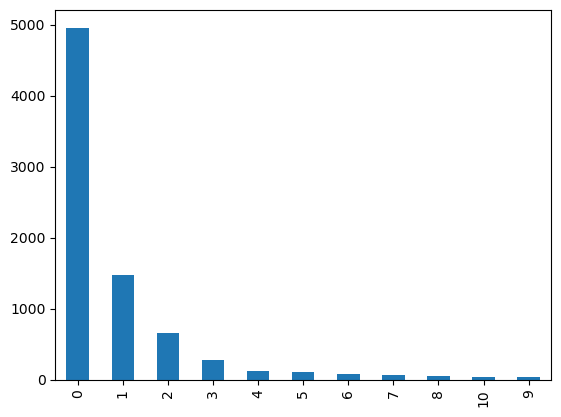

In [125]:
value_counts2.plot(kind='bar')  


#### Protein + gene_symbol + peptide

In [126]:
protein_gene_symbol_peptide = dict()
for key, value in blast_infos.items():
    pep_seq = key.split("+")[0]
    gene_symbol = key.split("+")[1]
    
    for info in value:
        prot_seq = info.split(";")[0]
        
        if protein_gene_symbol_peptide.get(prot_seq):
            if protein_gene_symbol_peptide.get(prot_seq).get(gene_symbol):
                protein_gene_symbol_peptide[prot_seq][gene_symbol].add(pep_seq)
            else:
                protein_gene_symbol_peptide[prot_seq][gene_symbol] = {pep_seq}
        else:
            protein_gene_symbol_peptide[prot_seq] = {gene_symbol:{pep_seq}} 

In [127]:
df = pd.DataFrame([(protein, gene_symbol, ",".join(peptide)) for protein, inner_dict in protein_gene_symbol_peptide.items() for gene_symbol, peptide in inner_dict.items()], 
                  columns=['protein', 'gene_symbol', 'peptide'])
# df.to_csv("/mnt/nfs/wangd/project/paper_db/count/blast_canonical_count/protein_gene_symbol_peptide.tsv", header=1, sep="\t", index = None)
df.to_csv("/home1/wangd/project/PXD010154/count/blast_canonical_count/protein_gene_symbol_peptide.tsv", header=1, sep="\t", index = None)

In [128]:
df

,protein,gene_symbol,peptide
0,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,PKP3,GVGGAVPGAVLEPVAPAPSVR
1,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...,PKP3,GVGGAVPGAVLEPVAPAPSVR
2,MQDGNFLLSALQPEAGVCSLALPSDLQLDRRGAEGPEAERLRAARV...,PKP3,GVGGAVPGAVLEPVAPAPSVR
3,MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...,HLA-DMB,"MAPCEFGVLNNLANVLSQHLNQK,VLLTCWDPEENKMAPCEFGVLN..."
4,MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...,HLA-DMB,"MAPCEFGVLNNLANVLSQHLNQK,VLLTCWDPEENKMAPCEFGVLN..."
...,...,...,...
6482,XADLGATKDRIISEINRLQQEATEHATESEERFRGLEEGQAQAGQC...,EMILIN1,VLLNDGGYYDPK
6483,MEIPPTNYPASRAALVAQNYINYQQGTPHRVFEVQKVKQASMEDIP...,LXN,QASMEDIPGRGHKYR
6484,MEFGLSWVFLVAILKGVQCEVQLVESGGVVVQPGGSLRLSCAASGF...,IGHV3-43,NSLYLQMNSLRTEDTTLYYCAK
6485,MAAQPPRPVGERSMGSSREAARAPARSPAWASTQASTPGAALAVQR...,LRRC34,AINLNRPILYGEQEESTVHVGR


#### Gene_symbol + peptide + protein

In [129]:
gene_symbol_peptide_protein = dict()
for key, value in blast_infos.items():
    prot_set = set()
    
    pep_seq = key.split("+")[0]
    gene_symbol = key.split("+")[1]
    
    for info in value:
        prot_set.add(info.split(";")[0])

    if gene_symbol_peptide_protein.get(gene_symbol):
        gene_symbol_peptide_protein[gene_symbol][pep_seq] = prot_set
    else:
        gene_symbol_peptide_protein[gene_symbol] = {pep_seq:prot_set}

In [130]:
gene_symbol_peptide = dict()
gene_symbol_protein = dict()
for gene_symbol,value in gene_symbol_peptide_protein.items():
    for peptide,protein in value.items():
        if gene_symbol_peptide.get(gene_symbol):
            gene_symbol_peptide[gene_symbol].add(peptide)
        else:
            gene_symbol_peptide[gene_symbol] = {peptide}
        
        if gene_symbol_protein.get(gene_symbol):
            gene_symbol_protein[gene_symbol].union(protein)
        else:
            gene_symbol_protein[gene_symbol] = protein
            
gene_symbol_peptide_str = {key: ','.join(value) for key, value in gene_symbol_peptide.items()}
gene_symbol_protein_str = {key: ','.join(value) for key, value in gene_symbol_protein.items()}

In [131]:
df = pd.DataFrame({'gene_symbol': list(gene_symbol_peptide.keys()),
                   'peptide': list(gene_symbol_peptide_str.values()),
                   'protein': list(gene_symbol_protein_str.values())})
# df.to_csv("/mnt/nfs/wangd/project/paper_db/count/blast_canonical_count/gene_symbol_peptide_protein.tsv", header=1, sep="\t", index = None)
df.to_csv("/home1/wangd/project/PXD010154/count/blast_canonical_count/gene_symbol_peptide_protein.tsv", header=1, sep="\t", index = None)

In [132]:
df

,gene_symbol,peptide,protein
0,PKP3,GVGGAVPGAVLEPVAPAPSVR,MPTRPVSFHERGGVGSRADYDTLSLRSLRLGPGGLDDRYSLVSEQL...
1,HLA-DMB,"MAPCEFGVLNNLANVLSQHLNQK,VLLTCWDPEENKMAPCEFGVLN...",MITFLPLLLGLSLGCTGAGGFVAHVESTCLLDDAGTPKDFTYCISF...
2,RPS6KA1,EITPPFKPAVAQPDDTFYFDTEFTSR,MPLAQLKEPWPLMELVPLDPENGQTSGEEAGLQPSKDEGVLKEISI...
3,CRYBG3,"GFTGNTEGSMLK,SSPSSVTNSSYDGESDSQHHLSCEPVFQTNR",MSSGRRRGSAPWHSFSRFFAPRSPSRDKEEEEEERPGTSPPPAPGR...
4,KRT79,"KQCQQLQTAIAEVEQR,QCQQLQTAIAEVEQR",MRSSVSRQTYSTKGGFSSNSASGGSGSQARTSFSSVTVSRSSGSGG...
...,...,...,...
1900,FRZB,NNYNYVIWAK,MVCGSPGGMLLLRAGLLALAALCLLRVPGARAAACEPVRIPLCKSL...
1901,EMILIN1,VLLNDGGYYDPK,XADLGATKDRIISEINRLQQEATEHATESEERFRGLEEGQAQAGQC...
1902,LXN,QASMEDIPGRGHKYR,MEIPPTNYPASRAALVAQNYINYQQGTPHRVFEVQKVKQASMEDIP...
1903,IGHV3-43,NSLYLQMNSLRTEDTTLYYCAK,MEFGLSWVFLVAILKGVQCEVQLVESGGVVVQPGGSLRLSCAASGF...


#### All 1-2 mismatch_nums Peptides Info Count

In [133]:
all_peptide = set()
all_gene_symbol = set()
all_protein = set()
all_transcript = set()
for key, value in blast_infos.items(): 
    pep_seq = key.split("+")[0]
    all_peptide.add(pep_seq)
    
    gene_symbol = key.split("+")[1]
    all_gene_symbol.add(gene_symbol)
    
    for info in value:
        all_protein.add(info.split(";")[0])
        all_transcript.add([x for x in info.split(" ") if x.startswith('transcript:')][0].split(':')[-1])

In [134]:
print("Number of peptides: {}".format(len(all_peptide)))
print("Number of gene_symbols: {}".format(len(all_gene_symbol)))
print("Number of transcript ids: {}".format(len(all_transcript)))
print("Number of protein seqs: {}".format(len(all_protein)))

Number of peptides: 3383
Number of gene_symbols: 1905
Number of transcript ids: 8319
Number of protein seqs: 6484


### Novel Peptides

In [135]:
fail_peps = all_res_peps - all_peptide

In [136]:
len(fail_peps)

127

In [137]:
df_fail_peps = final_pep_gene_symbol[final_pep_gene_symbol["sequence_x"].isin(fail_peps)]
df_fail_peps

,sequence_x,protein_accessions,peptidoform,gene_symbol
27,AAGFEEIEQDLTQRFEEK,GCA_170981,AAGFEEIEQDLTQRFEEK,DDX58
37,AAPQNGGSSEPPAAPR,GCA_277796,AAPQNGGSSEPPAAPR,ZFPM1
38,AAPQNGGSSEPPAAPR,GCA_277796,AAPQ[Deamidated]NGGSSEPPAAPR,ZFPM1
118,AEDMALYYCAK,GCA_264940,AEDM[Oxidation]ALYYC[Carbamidomethyl]AK,IGHV3-64D
123,AEDTAVYFCAK,GCA_294782,AEDTAVYFC[Carbamidomethyl]AK,NaN
...,...,...,...,...
6088,YFSTSVSWPGRGEPR,GCA_61687,YFSTSVSWPGRGEPR,HLA-C
6122,YIQQQKQQQQQQQQQQQQQQQQQR,GCA_231481,YIQQQKQQQQQQQQQ[Deamidated]QQQQQQQQR,ATXN3
6127,YKSDSDNQQGSGVPSR,GCA_310162,YKSDSDNQQGSGVPSR,NaN
6128,YKSDSDNQQGSGVPSR,GCA_310162,YKSDSDN[Deamidated]QQGSGVPSR,NaN


In [138]:
df_fail_peps_no_gene_symbol = df_fail_peps[df_fail_peps["gene_symbol"].isna()]
df_fail_peps_no_gene_symbol

,sequence_x,protein_accessions,peptidoform,gene_symbol
123,AEDTAVYFCAK,GCA_294782,AEDTAVYFC[Carbamidomethyl]AK,NaN
359,ANGGTTDYAAPVK,GCA_82883,ANGGTTDYAAPVK,NaN
360,ANGGTTDYAAPVK,GCA_82883,AN[Deamidated]GGTTDYAAPVK,NaN
468,ASGYTFTNNGITWVR,GCA_197511,ASGYTFTNNGITWVR,NaN
469,ASGYTYTDYYMHWVR,GCA_152779,ASGYTYTDYYMHWVR,NaN
470,ASGYTYTDYYMHWVR,GCA_152779,ASGYTYTDYYM[Oxidation]HWVR,NaN
491,ASQSISTWLAWYQQKPGK,GCA_213376,ASQSISTWLAWYQQKPGK,NaN
492,ASQSISTWLAWYQQKPGK,GCA_213376,ASQSISTWLAWYQ[Deamidated]Q[Deamidated]KPGK,NaN
493,ASQSISTWLAWYQQKPGK,GCA_213376,ASQ[Deamidated]SISTWLAWYQ[Deamidated]Q[Deamida...,NaN
870,DLCPLLSEHGLQCSLEPHLNSNLCVYCCK,GCA_125675,DLC[Carbamidomethyl]PLLSEHGLQ[Deamidated]C[Car...,NaN


In [139]:
len(set(df_fail_peps_no_gene_symbol["sequence_x"]))

25

In [140]:
auto = ahocorasick.Automaton()

for seq in fail_peps:
    auto.add_word(seq, seq)

auto.make_automaton()

In [142]:
peps_prots = {}
for prot_file in tqdm(glob('/home1/wangd/project/can_db/GCA_peps/*.fa')):
    prot_seqs = set()
    prots_dict = {}
    parsed_file = SeqIO.parse(prot_file, 'fasta')
    sample_name = prot_file.split('/')[-1].split('-')[1]

    for record in parsed_file:
        try:
            prots_dict[str(record.seq)].append(sample_name + ' ' +  str(record.id) + ' ' +  str(record.seq) + ' ' + str(record.description))
        except KeyError:
            prots_dict[str(record.seq)] = [sample_name + ' ' + str(record.id) + ' ' +  str(record.seq) + ' ' + str(record.description)]
#     print('Total number of unique protein sequences = {} in the fasta file: {}'.format(len(prots_dict.keys()), prot_file))

    #get non-canonical peptides that are found in canonical proteins from ensembl
    found_prots = set()

    for prot_seq in prots_dict.keys():
        for end_ind, found in auto.iter(prot_seq):
            found_prots.add(found)
            try:
                peps_prots[found].append(prots_dict[prot_seq])
            except KeyError:
                peps_prots[found] = [prots_dict[prot_seq]]

# print('Numner of peptides found in the protein files {} and number of peptides {}'.format(len(peps_prots), len(peps)))

100%|██████████| 97/97 [03:02<00:00,  1.88s/it]


In [143]:
sample_peps= {}
gene_ID_peps = {}
protein_ID_peps = {}
protein_Seq_peps = {}
transcript_ID_peps = {}
gene_symbol_peps = {}
peps_infos = {}
res_infos = {}
for pep in tqdm(fail_peps):
    prots = [x.split(' ') for xs in peps_prots[pep] for x in xs]
    samples, proteins, proteins_seq, genes, gene_symbols, transcripts, gene_biotypes = set(), set(), set(), set(), set(), set(), set()

    for prot in prots:
        samples.add(prot[0])
        proteins.add(prot[1])
        proteins_seq.add(prot[2])
        genes.add([x for x in prot if x.startswith('gene:')][0].split(':')[-1])
        transcripts.add([x for x in prot if x.startswith('transcript:')][0].split(':')[-1])
        gene_biotypes.add([x for x in prot if x.startswith('gene_biotype:')][0].split(':')[-1])

        if res_infos.get(prot[2]):
            res_infos[prot[2]][0].add(pep)
            res_infos[prot[2]][1].add(prot[0])
        else:
            res_infos[prot[2]] = [{pep},{prot[0]},set()]

        try:
            gene_symbols.add([x for x in prot if x.startswith('gene_symbol:')][0].split(':')[-1])
            res_infos[prot[2]][2].add([x for x in prot if x.startswith('gene_symbol:')][0].split(':')[-1])
        except IndexError:
            pass

    peps_infos[pep] = [','.join(gene_symbols), ','.join(gene_biotypes), ','.join(samples), ','.join(proteins), ','.join(proteins_seq), ','.join(genes), ','.join(transcripts)]

    for sample in samples:
        try:
            sample_peps[sample].add(pep)
        except KeyError:
            sample_peps[sample] = set()
            sample_peps[sample].add(pep)

    for gene in genes:
        try:
            gene_ID_peps[gene].add(pep)
        except KeyError:
            gene_ID_peps[gene] = set()
            gene_ID_peps[gene].add(pep)

    for prot_id in proteins:
        try:
            protein_ID_peps[prot_id].add(pep)
        except KeyError:
            protein_ID_peps[prot_id] = set()
            protein_ID_peps[prot_id].add(pep)

    for prot_seq in proteins_seq:
        try:
            protein_Seq_peps[prot_seq].add(pep)
        except KeyError:
            protein_Seq_peps[prot_seq] = set()
            protein_Seq_peps[prot_seq].add(pep)

    for transcript in transcripts:
        try:
            transcript_ID_peps[transcript].add(pep)
        except KeyError:
            transcript_ID_peps[transcript] = set()
            transcript_ID_peps[transcript].add(pep)

    for gene_symbol in gene_symbols:
        try:
            gene_symbol_peps[gene_symbol].add(pep)
        except KeyError:
            gene_symbol_peps[gene_symbol] = set()
            gene_symbol_peps[gene_symbol].add(pep)

100%|██████████| 127/127 [00:00<00:00, 1375.12it/s]


#### peptide_gca_proteins.tsv

In [144]:
peptide_gca_proteins = pd.DataFrame.from_dict(res_infos, orient='index')
peptide_gca_proteins.columns = ["matching_peptides","sample names","gene_symbol of matching protein"]
peptide_gca_proteins.index.name = "matching_protein_sequence"

# peptide_gca_proteins["peptides_nums"] =  peptide_gca_proteins["matching_peptides"].apply(lambda x: len(x))
# peptide_gca_proteins["sample_nums"] =  peptide_gca_proteins["sample names"].apply(lambda x: len(x))
# peptide_gca_proteins["gene_symbol of matching protein_nums"] =  peptide_gca_proteins["gene_symbol of matching protein"].apply(lambda x: len(x))
peptide_gca_proteins["matching_peptides"] =  peptide_gca_proteins["matching_peptides"].apply(lambda x: ",".join(x))
peptide_gca_proteins["sample names"] =  peptide_gca_proteins["sample names"].apply(lambda x: ",".join(x))
peptide_gca_proteins["gene_symbol of matching protein"] =  peptide_gca_proteins["gene_symbol of matching protein"].apply(lambda x: ",".join(x))

In [145]:
peptide_gca_proteins

,matching_peptides,sample names,gene_symbol of matching protein
matching_protein_sequence,,,
MSAFEKPQIIAHIQKGFNYTVFDCKWVPCSAKFVTMGNFARGTGVIQLYEIQHGDLKLLREIEKAKPIKCGTFGATSLQQRYLATGDFGGNLHIWNLEAPEMPVYSVKGHKEIINAIDGIGGLGIGEGAPEIVTGSRDGTVKVWDPRQKDDPVANMEPVQGENKRDCWTVAFGNAYNQEERVVCAGYDNGDIKLFDLRNMALRWETNIKNGVCSLEFDRKDISMNKLVATSLEGKFHVFDVRTQHPTKGFASVSEKAHKSTVWQVRHLPQNRELFLTAGGAGGLHLWKYEYPIQRSKKDSEGIEMGVAGSVSLLQNVTLSTQPISSLDWSPDKRGLCVCSSFDQTVRVLIVTKLNKI,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92
XRNMALRWETNIKNGVCSLEFDRKDISMNKLVATSLEGKFHVFDVRTQHPTKGFASVSEKAHKSTVWQVRHLPQNRELFLTAGGAGGLHLWK,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92
MPVYSVKGHKEIINAIDGIGGLGIGEGAPEIVTGSRDGTVKVWDPRQKDDPVANMEPVQGENKRDCWTVAFGNAYNQEERVVCAGYDNGDIKLFDLRNMALRWETNIKNGVCSLEFDRKDISMNKLVATSLEGKFHVFDVRTQHPTKGFASVSEKAHKSTVWQVRHLPQNRELFLTAGGAGGLHLWK,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92
MSAFEKPQIIAHIQKGFNYTVFDCKWVPCSAKFVTMGNFARGTGVIQLYEIQHGDLKLLREIEKAKPIKCGTFGATSLQQRYLATGDFGGNLHIWNLEAPEMPVYSVKGHKEIINAIDGIGGLGIGEGAPEIVTGSRDGTVKVWDPRQKDDPVANMEPVQGENKRDCWTVAFGNAYNQEERVVCAGYDNGDIKLFDLRNMALRWETNIKNGVCSLEFDRKDISMNKLVATSLEGKFHVFDVRTQHPTKGFASVSEKAHKSTVWQVRHLPQNRELFLTAGGAGGLHLWK,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92
MGAQLSGGRGAPEPAQTQPQPQPQPAAPEGPEQPRHPPQPQPQPQPQPQPQPEPEPSPWGPLDDVRFLIACTSWY,HPPQPQPQPQPQPQPQPEPEPSPWGPLDDVR,"GCA_018469685.1,GCA_018472565.1,GCA_018469415....",MMP24OS
...,...,...,...
MWGGPGSPGGCGDGGGAGGATGTAPLRRRSRRPSADPGARGDCSVRDPEDTAMPGRAEAGEAEEEAGAGSGSEAEEDALWERIEGVRHRLARALNPAKLTPYLRQCRVIDEQDEEEVLSTYRFPCRVNRTGRLMDILRCRGKRGYEAFLEALEFYYPEHFTLLTGQEPAQRCSMILDEEGPEGLTQFLMTEVRRLREARKSQLQREQQLQARGRVLEEERAGLEQRLRDQQQAQERCQRLREDWEAGSLELLRLKDENYMIAMRLAQLSEEKNSAVLRSRDLQLAVDQLKLKVSRLEEECALLRRARGPPPGAEEKEKEKEKEPDNVDLVSELRAENQRLTASLRELQEGLQQEASRPGAPGSERILLDILEHDWREAQDSRQELCQKLHAVQGELQWAEELRDQYLQEMEDLRLKHRTLQKDCDLYKHRMATVLAQLEEIEKERDQAIQSRDRIQLQYSQSLIEKDQYRKQVRGLEAERDELLTTLTSLEGTKALLEVQLQRAQGGTCLKACASSHSLCSNLSSTWSLSEFPSPLGGPEATGEAAVMGGPEPHNSEEATDSEKEINRLSILPFPPSAGSILRRQREEDPAPPKRSFSSMSDITGSVTLKPWSPGLSSSSSSDSVWPLGKPEGLLARGCGLDFLNRSLAIRVSGRSPPGGPEPQDKGPDGLSFYGDRWSGAVVRRVLSGPGSARMEPREQRVEAAGLEGACLEAEAQQRTLLWNQGSTLPSLMDSKACQSFHEALEAWAKGPGAEPFYIRANLTLPERADPHALCVKAQEILRLVDSAYKRRQEWFCTRVDPLTLRDLDRGTVPNYQRAQQLLEVQEKCLPSSRHRGPRSNLKKRALDQLRLVRPKPVGAPAGDSPDQLLLEPCAEPERSLRPYSLVRPLLVSALRPVVLLPECLAPRLIRNLLDLPSSRLDFQVCPAESLSGEELCPSSAPGAPKAQPATPGLGSRIRAIQESVGKKHCLLELGARGVRELVQNEIYPIVIHVEVTEKNVREVRGLLGRPGWRDSELLRQCRGSEQVLWGLPCSWVQVPAHEWGHAEELAKVVRGRILQEQARLVWVECGSSRGCPSSSEA,GDCSVRDPEDTAMPGR,"GCA_018469405.1,GCA_018469675.1",CARD10
MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTPAKKTDIPWRLKQMLDILVYEEQQQAAAGEAGPCLEYLLQHKILETLCTLGKAEYPPGMRQQVFQFFSKVLAQVQHPLLHYLSVHRPVQKLLRLGGTASGSVTEKEEVQFTTVLCSKIQQDPELLAYILEGKKIVGRKKACGEPTALPKDTTSHGDKDCSHDGAPARPQLDGESCGAQALNSHMPAETEELDGGTTESNLITSLLGLCQSKKSRVALKAQENLLLLVSMASPAAATYLVQSSACCPAIVRHLCQLYRSMPVFLDPADIAALEGISWRLPSAPSDEASFPGKEALAAFLGWFDYCDHLITEAHTVVADALAKAVAENFFVETLQPQLLHVSEQSILTSTALLTAMLRQLRSPALLREAVAFLLGTDRQPEAPGDNPHTLYAHLIGHCDHLSDEISITTLRLFEELLQKPHEGIIHSLVLRNLEGRPYVAWGSPEPESYEDTLDLEEDPYFTDSFLDSGFQTPAKPRLAPATSYDGKTAVTEIVNSFLCLVPEEAKTSAFLEETGYDTYVHDAYGLFQECSSRVASWGWPLTPTPLDPHEPERPFFEGHFLRVLFDRMSRILDQPYSLNLQVTSVLSRLALFPHPHIHEYLLDPYISLAPGCRSLFSVLVRVIGDLMQRIQRVPQFPGKLLLVRKQLTGQAPGEQLDHQTLLQGVVVLEEFCKELAAIAFVKFPPHDPRQNVSPAPEGQV,SMPVFLDPADIAALEGISWR,"GCA_018473315.1,GCA_018505825.1,GCA_018852615....",FAM160B2
MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTPAKKTDIPWRLKQMLDILVYEEQQQAAAGEAGPCLEYLLQHKILETLCTLGKAEYPPGMRQQVFQFFSKVLAQVQHPLLHYLSVHRPVQKLLRLGGTASGSVTEKEEVQFTTVLCSKIQQDPELLAYILEGKKIVGRKKACGEPTALPKDTTSHGDKDCSHDGAPARPQLDGESCGAQALNSHMPAETEELDGGTTESTLITSLLGLCQSKKSRVALKAQENLLLLVSMASPAAATYLVQSSACCPAIVRHLCQLYRSMPVFLDPADIAALEGISWRLPSAPSDEASFPGKEALAAFLGWFDYCDHLITEAHTVVADALAKAVAENFFVETLQPQLLHVSEQSILTSTALLTAMLRQLRSPALLREAVAFLLGTDRQPEAPGDNPHTLYAHLIGHCDHLSDEISITTLRLFEELLQKPHEGIIHSLVLRNLEGRPYVAWGSPEPESYEDTLDLEEDPYFTDSFLDSGFQTPAKPRLAPATSYD

In [146]:
peptide_gca_proteins.to_csv("/home1/wangd/project/PXD010154/count/blast_canonical_count/peptide_gca_proteins.tsv", header=1, sep="\t")

#### matching_gca_canoical_proteins.tsv

In [147]:
matching_gca_canoical_proteins = pd.read_table("/home1/wangd/project/PXD010154/count/blast_canonical_count/peptide_gca_proteins.tsv")

In [148]:
matching_gca_canoical_proteins

,matching_protein_sequence,matching_peptides,sample names,gene_symbol of matching protein
0,MSAFEKPQIIAHIQKGFNYTVFDCKWVPCSAKFVTMGNFARGTGVI...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92
1,XRNMALRWETNIKNGVCSLEFDRKDISMNKLVATSLEGKFHVFDVR...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92
2,MPVYSVKGHKEIINAIDGIGGLGIGEGAPEIVTGSRDGTVKVWDPR...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92
3,MSAFEKPQIIAHIQKGFNYTVFDCKWVPCSAKFVTMGNFARGTGVI...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92
4,MGAQLSGGRGAPEPAQTQPQPQPQPAAPEGPEQPRHPPQPQPQPQP...,HPPQPQPQPQPQPQPQPEPEPSPWGPLDDVR,"GCA_018469685.1,GCA_018472565.1,GCA_018469415....",MMP24OS
...,...,...,...,...
817,MWGGPGSPGGCGDGGGAGGATGTAPLRRRSRRPSADPGARGDCSVR...,GDCSVRDPEDTAMPGR,"GCA_018469405.1,GCA_018469675.1",CARD10
818,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,"GCA_018473315.1,GCA_018505825.1,GCA_018852615....",FAM160B2
819,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,"GCA_018469685.1,GCA_018471515.1",FAM160B2
820,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,GCA_018504365.1,FAM160B2


In [149]:
def get_blast_canonical_info(x):
    blast_res = {}
    non_canonical_seq = x["matching_protein_sequence"]

    if gene_symbol_proteins.get(x["gene_symbol of matching protein"]):
        canonical_seqs = gene_symbol_proteins[x["gene_symbol of matching protein"]]

        for canonical_seq in canonical_seqs:
            seq = canonical_seq.split(";")[0]
            alignments = pairwise2.align.globalms(sequenceA = seq,sequenceB = non_canonical_seq, match = 1,mismatch = -1,open = -2,extend = -1,one_alignment_only=True)
            alignment = alignments[0]
            score = alignment.score
            if blast_res:
                for value in blast_res.values():
                    if value.score > score:
                        continue
                    elif value == score:
                        blast_res[canonical_seq] = alignment
                    else:
                        blast_res = {canonical_seq:alignment}
            else:
                blast_res = {canonical_seq:alignment}

        final_res = []
        for key,value in blast_res.items():
            res = []
            i = 0
            j = 0
            for AA1, AA2 in zip(value.seqA, value.seqB):
                i += 1
                j += 1
                if AA1 == AA2:
                    continue
                if AA1 == '-' and AA2 != '-':
                    # insertion
                    res.append(str(i) + "-" + ">" + AA2)
                    i -= 1
                elif AA2 == '-' and AA1 != '-':
                    # deletion
                    res.append(str(i) + AA1 + ">" + "-")
                    j -= 1
                else:
                    # substitution
                    res.append(str(i) + AA1 + ">" + AA2)

            final_res.append({key:res})

        return final_res
    else:
        return ""

In [151]:
matching_gca_canoical_proteins["match_info"] = matching_gca_canoical_proteins.parallel_apply( get_blast_canonical_info,axis=1)

In [152]:
matching_gca_canoical_proteins

,matching_protein_sequence,matching_peptides,sample names,gene_symbol of matching protein,match_info
0,MSAFEKPQIIAHIQKGFNYTVFDCKWVPCSAKFVTMGNFARGTGVI...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,
1,XRNMALRWETNIKNGVCSLEFDRKDISMNKLVATSLEGKFHVFDVR...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,
2,MPVYSVKGHKEIINAIDGIGGLGIGEGAPEIVTGSRDGTVKVWDPR...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,
3,MSAFEKPQIIAHIQKGFNYTVFDCKWVPCSAKFVTMGNFARGTGVI...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,
4,MGAQLSGGRGAPEPAQTQPQPQPQPAAPEGPEQPRHPPQPQPQPQP...,HPPQPQPQPQPQPQPQPEPEPSPWGPLDDVR,"GCA_018469685.1,GCA_018472565.1,GCA_018469415....",MMP24OS,[{'MGAQLSGGRGAPEPAQTQPQPQPQPAAPEGPEQPRHPPQPQPQ...
...,...,...,...,...,...
817,MWGGPGSPGGCGDGGGAGGATGTAPLRRRSRRPSADPGARGDCSVR...,GDCSVRDPEDTAMPGR,"GCA_018469405.1,GCA_018469675.1",CARD10,[{'MPGRAEAGEAEEEAGAGSGSEAEEDALWERIEGVRHRLARALN...
818,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,"GCA_018473315.1,GCA_018505825.1,GCA_018852615....",FAM160B2,
819,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,"GCA_018469685.1,GCA_018471515.1",FAM160B2,
820,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,GCA_018504365.1,FAM160B2,


In [153]:
matching_gca_canoical_proteins = matching_gca_canoical_proteins.explode("match_info", ignore_index=True)

In [154]:
matching_gca_canoical_proteins

,matching_protein_sequence,matching_peptides,sample names,gene_symbol of matching protein,match_info
0,MSAFEKPQIIAHIQKGFNYTVFDCKWVPCSAKFVTMGNFARGTGVI...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,
1,XRNMALRWETNIKNGVCSLEFDRKDISMNKLVATSLEGKFHVFDVR...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,
2,MPVYSVKGHKEIINAIDGIGGLGIGEGAPEIVTGSRDGTVKVWDPR...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,
3,MSAFEKPQIIAHIQKGFNYTVFDCKWVPCSAKFVTMGNFARGTGVI...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,
4,MGAQLSGGRGAPEPAQTQPQPQPQPAAPEGPEQPRHPPQPQPQPQP...,HPPQPQPQPQPQPQPQPEPEPSPWGPLDDVR,"GCA_018469685.1,GCA_018472565.1,GCA_018469415....",MMP24OS,{'MGAQLSGGRGAPEPAQTQPQPQPQPAAPEGPEQPRHPPQPQPQP...
...,...,...,...,...,...
817,MWGGPGSPGGCGDGGGAGGATGTAPLRRRSRRPSADPGARGDCSVR...,GDCSVRDPEDTAMPGR,"GCA_018469405.1,GCA_018469675.1",CARD10,{'MPGRAEAGEAEEEAGAGSGSEAEEDALWERIEGVRHRLARALNP...
818,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,"GCA_018473315.1,GCA_018505825.1,GCA_018852615....",FAM160B2,
819,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,"GCA_018469685.1,GCA_018471515.1",FAM160B2,
820,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,GCA_018504365.1,FAM160B2,


In [155]:
matching_gca_canoical_proteins["canonical_protein_seq"] = matching_gca_canoical_proteins["match_info"].apply(lambda x: list(x.keys())[0].split(";")[0] if x and list(x.keys())[0] != "" else None)
matching_gca_canoical_proteins["number_mismatches"] = matching_gca_canoical_proteins["match_info"].apply(lambda x: len(list(x.values())[0]) if x and list(x.values())[0] != "" else None)
matching_gca_canoical_proteins["mismatch_info"] = matching_gca_canoical_proteins["match_info"].apply(lambda x: ",".join(list(x.values())[0]) if x and list(x.values())[0] != "" else None)
matching_gca_canoical_proteins["canonical_protein_ID"] = matching_gca_canoical_proteins["match_info"].apply(lambda x: list(x.keys())[0].split(";")[1].split(" ")[0] if x and list(x.keys())[0] != "" else None)
matching_gca_canoical_proteins["canonical_transcript_ID"] = matching_gca_canoical_proteins["match_info"].apply(lambda x: [x for x in list(x.keys())[0].split(" ") if x.startswith('transcript:')][0].split(':')[-1] if x and list(x.keys())[0] != "" else None)

In [156]:
matching_gca_canoical_proteins = matching_gca_canoical_proteins.drop("match_info", axis=1)

In [157]:
matching_gca_canoical_proteins

,matching_protein_sequence,matching_peptides,sample names,gene_symbol of matching protein,canonical_protein_seq,number_mismatches,mismatch_info,canonical_protein_ID,canonical_transcript_ID
0,MSAFEKPQIIAHIQKGFNYTVFDCKWVPCSAKFVTMGNFARGTGVI...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,None,NaN,None,None,None
1,XRNMALRWETNIKNGVCSLEFDRKDISMNKLVATSLEGKFHVFDVR...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,None,NaN,None,None,None
2,MPVYSVKGHKEIINAIDGIGGLGIGEGAPEIVTGSRDGTVKVWDPR...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,None,NaN,None,None,None
3,MSAFEKPQIIAHIQKGFNYTVFDCKWVPCSAKFVTMGNFARGTGVI...,LVATSLEGKFHVFDVR,"GCA_018472845.1,GCA_018852615.1,GCA_018469935....",WDR92,None,NaN,None,None,None
4,MGAQLSGGRGAPEPAQTQPQPQPQPAAPEGPEQPRHPPQPQPQPQP...,HPPQPQPQPQPQPQPQPEPEPSPWGPLDDVR,"GCA_018469685.1,GCA_018472565.1,GCA_018469415....",MMP24OS,MGAQLSGGRGAPEPAQTQPQPQPQPAAPEGPEQPRHPPQPQPQPQP...,4.0,"50->P,50->Q,50->P,50->E",ENSP00000488948.1,ENST00000424358.1
...,...,...,...,...,...,...,...,...,...
817,MWGGPGSPGGCGDGGGAGGATGTAPLRRRSRRPSADPGARGDCSVR...,GDCSVRDPEDTAMPGR,"GCA_018469405.1,GCA_018469675.1",CARD10,MPGRAEAGEAEEEAGAGSGSEAEEDALWERIEGVRHRLARALNPAK...,54.0,"1->M,1->W,1->G,1->G,1->P,1->G,1->S,1->P,1->G,1...",ENSP00000384570.1,ENST00000403299.5
818,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,"GCA_018473315.1,GCA_018505825.1,GCA_018852615....",FAM160B2,None,NaN,None,None,None
819,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,"GCA_018469685.1,GCA_018471515.1",FAM160B2,None,NaN,None,None,None
820,MLSRLGALLQEAVGAREPSIDLLQAFVEHWKGITHYYIESTDESTP...,SMPVFLDPADIAALEGISWR,GCA_018504365.1,FAM160B2,None,NaN,None,None,None


In [158]:
matching_gca_canoical_proteins.to_csv("/home1/wangd/project/PXD010154/count/blast_canonical_count/matching_gca_canoical_proteins.tsv", header=1, sep="\t",index = None)

#### Novel Peptides Info Count

In [159]:
print("Number of peptides: {}".format(len(fail_peps)))
print("Number of GCA samples matched: {}".format(len(sample_peps)))
print("Number of gene ids matched: {}".format(len(gene_ID_peps)))
print("Number of transcript ids matched: {}".format(len(transcript_ID_peps)))
print("Number of protein ids matched: {}".format(len(protein_ID_peps)))
print("Number of protein seqs matched: {}".format(len(protein_Seq_peps)))
print("Number of gene_symbols matched: {}".format(len(gene_symbol_peps)))

Number of peptides: 127
Number of GCA samples matched: 97
Number of gene ids matched: 1939
Number of transcript ids matched: 5150
Number of protein ids matched: 5150
Number of protein seqs matched: 822
Number of gene_symbols matched: 74


#### Protein_with_two_peptides

In [160]:
protein_with_two_peptides = {}
for protein_seq, peptide_seqs in protein_Seq_peps.items():
    if len(peptide_seqs) > 1:
        protein_with_two_peptides[protein_seq] = ",".join(peptide_seqs)

In [161]:
len(protein_with_two_peptides)

123

In [162]:
df_protein_with_two_peptides = pd.DataFrame(list(protein_with_two_peptides.items()), columns=['protein_seq', 'peptides'])

In [105]:
df_protein_with_two_peptides.to_csv(r"protein_with_two_peptides.tsv", header=1, sep="\t",index = None)

In [106]:
df_protein_with_two_peptides

,protein_seq,peptides
0,MKLLTGLVFCSLVLGVSSRSFFSFLGEAFDGARDMWRAYSDMREAN...,"GPGGVWAAEAISDARENIQR,RGPGGVWAAEAISDARENIQR,GNY..."
1,MKLLTGLVFCSLVLGVSSRSFFSFLGEAFDGARDMWRAYSDMREAN...,"GPGGVWAAEAISDARENIQR,RGPGGVWAAEAISDARENIQR,GNY..."
2,MKLLTGLVFCSLVLGVSSRSFFSFLGEAFDGARDMWRAYSDMREAN...,"GPGGVWAAEAISDARENIQR,RGPGGVWAAEAISDARENIQR,GNY..."
3,MKLLTGLVFCSLVLGVSSRSFFSFLGEAFDGARDMWRAYSDMREAN...,"GPGGVWAAEAISDARENIQR,RGPGGVWAAEAISDARENIQR,GNY..."
4,MGCHSSKSTTVAAESQKLEEECEGREPGLETGTQAADCKDAPLKDG...,"LEEECEGREPGLETGTQAADCK,LEEECEGREPGLETGTQAADCKD..."
...,...,...
118,VTGSGHASSTPGGEKETSATQRSSVPSSTEKNAVSMTSSVLSSHSP...,"PAPGSTAPAAHGVTSAPESR,PAPGSTAPPAHGVTSAPESR"
119,MTPGTQSPFFLLLLLTVLTVVTGSGHASSTPGGEKETSATQRSSVP...,"PAPGSTAPAAHGVTSAPESR,PAPGSTAPPAHGVTSAPESR"
120,MVFRRFVEVGRVAYVSFGPHAGKLVAIVDVIDQNRALVDGPCTQVR...,"GTAAAAAAAAAAAAK,KAPGTKGTAAAAAAAAAAAAK"
121,AILKGVQCEVQLVESAGGLVQPGGSLRLSCAASGFTCSNAWMSWVR...,"SKANGGTTDYAAPVK,ANGGTTDYAAPVK"
